In [4]:
pip install wheel==0.41.2 

  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install orbit-ml

Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите хотя бы 5 метрик.

1) CTR, на момент флэшмоба данная метрика одна из самых основных, так как кол-во постов и лайков во время флэщмоба ожидаемо увеличится. 
2) Кол-во постов. Это прямая метрика участия во флэшмобе и отражает, насколько пользователи были заинтересованы в данном мероприятии.
3) Кол-во лайков, Общая сумма лайков, полученных на постах, участвующих в флэшмобе. 
4) Кол-во пользователей.
5) Число новых пользователей

Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [30]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза

In [27]:
import causalimpact
from causalimpact import CausalImpact

In [23]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import numpy as np

In [4]:
connection = { 
    'host' : 'https://clickhouse.lab.karpov.courses', 
    'password' : 'dpo_python_2020', 
    'user' : 'student', 
    'database' : 'simulator'
}

In [18]:
# Извлекаем нужные нам метрики для анализа 
q = """
SELECT 
    toDate(time) as day,
    countIf(action = 'like') as likes, 
    countIf(action = 'view') as views,
    countIf(action = 'like')/countIf(action = 'view') CTR, 
    count(DISTINCT user_id) as users
FROM 
    simulator_20240620.feed_actions 
WHERE 
    day >= toDate('2024-05-14') AND 
    day <= toDate('2024-06-21')
GROUP BY day 
ORDER BY day 
"""
df = ph.read_clickhouse(q, connection=connection)

In [6]:
df.head()

,day,likes,views,CTR,users
0,2024-05-14,60423,299437,0.201789,7773
1,2024-05-15,66198,318998,0.207519,8891
2,2024-05-16,62175,299557,0.207556,8641
3,2024-05-17,57028,271211,0.210272,8567
4,2024-05-18,54446,261839,0.207937,8980


In [34]:
# Используем время как индекс для CasualImpact 
df = df.set_index('day')

In [8]:
period_before = ['2024-05-14', '2024-06-13']
period_after = ['2024-06-14', '2024-06-20']

In [9]:
impact_CTR = CausalImpact(data=pd.Series(df.CTR), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) 

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


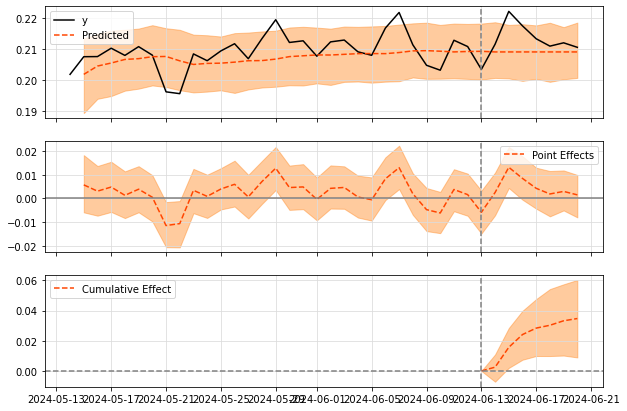

In [10]:
impact_CTR.plot()

In [11]:
print(impact_CTR.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.46 (0.01)
95% CI                    [0.21, 0.21]       [1.44, 1.49]

Absolute effect (s.d.)    0.0 (0.0)          0.03 (0.01)
95% CI                    [0.0, 0.01]        [0.01, 0.06]

Relative effect (s.d.)    2.37% (0.92%)      2.37% (0.92%)
95% CI                    [0.62%, 4.22%]     [0.62%, 4.22%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.4%

For more details run the command: print(impact.summary('report'))


In [12]:
print(impact_CTR.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.21, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.0 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.46. The 95% interval of this prediction is [1.44, 1.49].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

In [15]:
impact_likes = CausalImpact(data=pd.Series(df.likes), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события

impact_views = CausalImpact(data=pd.Series(df.views), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события

impact_users = CausalImpact(data=pd.Series(df.users), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события

In [16]:
df.head()

,likes,views,CTR,users
day,,,,
2024-05-14,60423,299437,0.201789,7773
2024-05-15,66198,318998,0.207519,8891
2024-05-16,62175,299557,0.207556,8641
2024-05-17,57028,271211,0.210272,8567
2024-05-18,54446,261839,0.207937,8980


In [31]:
#тренд

#причёсываем
data = df.drop("day", axis=1).astype(np.float32)

#стандартизуем
normed_data, _ = causalimpact.misc.standardize(data)

obs_data = normed_data.iloc[:41, 1]

trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

In [35]:
impact_views_trend = CausalImpact(data=pd.Series(df.views), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after, #период после события
                      model=trend_component) 

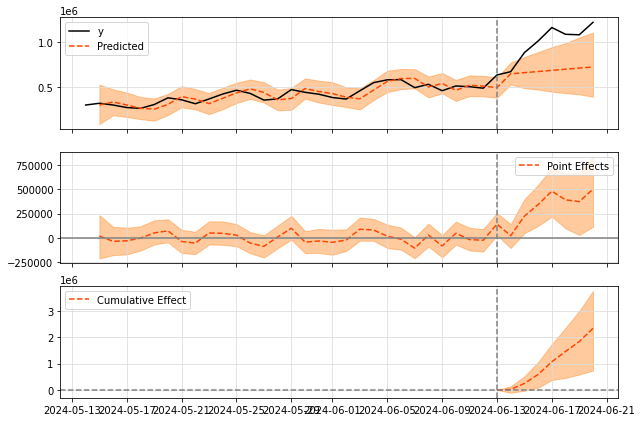

In [37]:
impact_views_trend.plot()

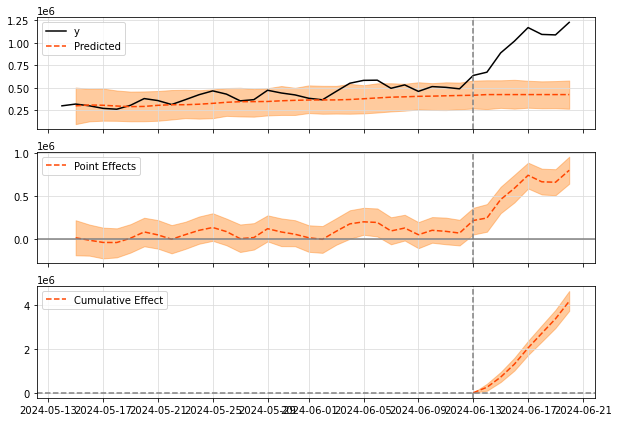

In [39]:
impact_views.plot()

In [40]:
impact_likes_trend = CausalImpact(data=pd.Series(df.likes), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after, #период после события
                      model=trend_component) 


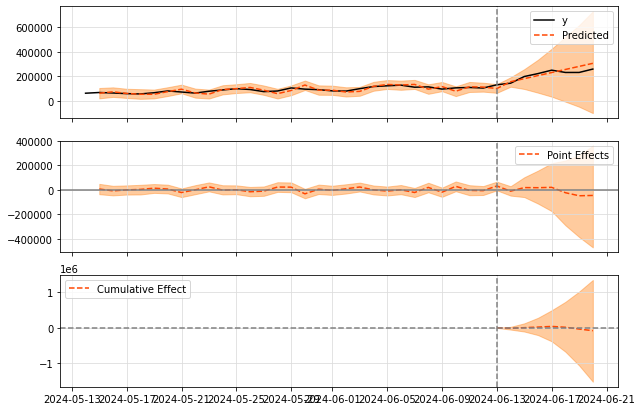

In [41]:
impact_likes_trend.plot()

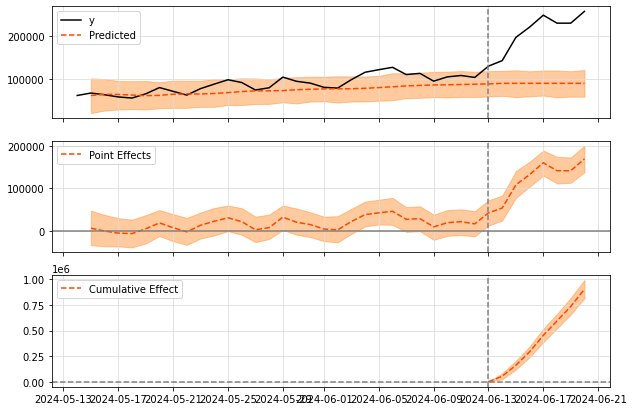

In [42]:
impact_likes.plot()

Флэшмоб оказал положительное влияние на количество лайков и просмотров, вероятно увеличив эти метрики на 72.63% и 70.4% соответственно. Влияние на CTR и количество пользователей менее значительное и сопровождается высокой неопределенностью. Высокие значения стандартных отклонений и широкие доверительные интервалы указывают на высокую изменчивость данных, что снижает уверенность в точных оценках эффектов флэшмоба.

Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы и аргументируйте их.

Чтобы найти долгосрочные эффекты, можно использовать CasualImpact для иследования метрик до флэшмоба и после.<br>
Для этого был взять период в месяц после флэшмоба 

In [61]:
# Извлекаем нужные нам метрики для анализа 
q = """
SELECT 
    toStartOfHour(time) hour_time,
    countIf(action = 'like') as likes, 
    countIf(action = 'view') as views,
    countIf(action = 'like')/countIf(action = 'view') CTR, 
    count(DISTINCT user_id) as users
FROM 
    simulator_20240620.feed_actions 
WHERE 
    hour_time >= toDateTime('2024-05-14 00:00:00') AND 
    hour_time <= toDateTime('2024-07-21 00:00:00')
GROUP BY hour_time 
ORDER BY hour_time 
"""
df = ph.read_clickhouse(q, connection=connection)

In [63]:
df

,hour_time,likes,views,CTR,users
0,2024-05-14 00:00:00,2522,11727,0.215059,570
1,2024-05-14 01:00:00,1984,9661,0.205362,458
2,2024-05-14 02:00:00,1434,6823,0.210171,346
3,2024-05-14 03:00:00,1130,5322,0.212326,268
4,2024-05-14 04:00:00,1018,5079,0.200433,284
...,...,...,...,...,...
1628,2024-07-20 20:00:00,5881,29355,0.200341,2212
1629,2024-07-20 21:00:00,5855,28331,0.206664,1941
1630,2024-07-20 22:00:00,5608,26712,0.209943,1723
1631,2024-07-20 23:00:00,4888,23898,0.204536,1514


In [64]:
# Используем время как индекс для CasualImpact 
df = df.set_index('hour_time')

In [65]:
period_before = ['2024-05-14 00:00:00', '2024-06-13 00:00:00']
period_after = ['2024-06-21 00:00:00', '2024-07-21 00:00:00']

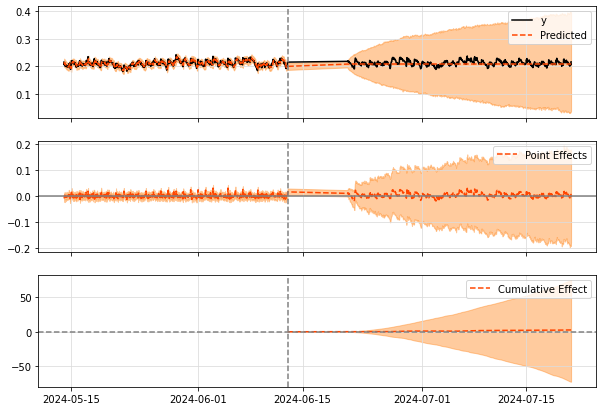

In [66]:
impact_CTR = CausalImpact(data=pd.Series(df.CTR), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события
impact_CTR.plot()

In [67]:
print(impact_CTR.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               152.77
Prediction (s.d.)         0.21 (0.05)        150.22 (39.45)
95% CI                    [0.1, 0.31]        [71.16, 225.81]

Absolute effect (s.d.)    0.0 (0.05)         2.55 (39.45)
95% CI                    [-0.1, 0.11]       [-73.04, 81.61]

Relative effect (s.d.)    1.7% (26.26%)      1.7% (26.26%)
95% CI                    [-48.62%, 54.33%]  [-48.62%, 54.33%]

Posterior tail-area probability p: 0.48
Posterior prob. of a causal effect: 52.25%

For more details run the command: print(impact.summary('report'))


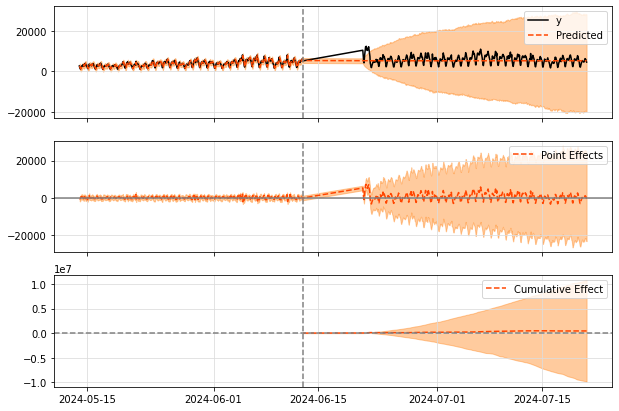

In [68]:
impact_likes = CausalImpact(data=pd.Series(df.likes), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события
impact_likes.plot()

In [70]:
print(impact_likes.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    5715.83            4121115.0
Prediction (s.d.)         5105.1 (7534.05)   3680779.25 (5432049.53)
95% CI                    [-9182.97, 20349.97][-6620918.28, 14672329.07]

Absolute effect (s.d.)    610.73 (7534.05)   440335.75 (5432049.53)
95% CI                    [-14634.14, 14898.8][-10551214.07, 10742033.28]

Relative effect (s.d.)    11.96% (147.58%)   11.96% (147.58%)
95% CI                    [-286.66%, 291.84%][-286.66%, 291.84%]

Posterior tail-area probability p: 0.47
Posterior prob. of a causal effect: 53.35%

For more details run the command: print(impact.summary('report'))


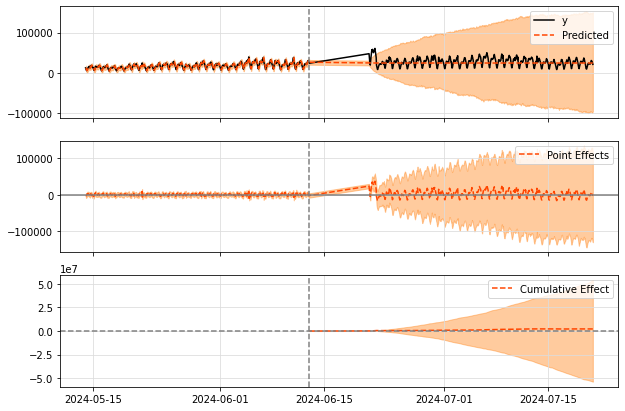

In [71]:
impact_views = CausalImpact(data=pd.Series(df.views), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события
impact_views.plot()

In [72]:
print(impact_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    27118.39           19552362.0
Prediction (s.d.)         24048.79 (34637.74)17339180.0 (24973811.74)
95% CI                    [-44185.17, 91592.32][-31857505.3, 66038058.3]

Absolute effect (s.d.)    3069.6 (34637.74)  2213182.0 (24973811.74)
95% CI                    [-64473.92, 71303.56][-46485696.3, 51409867.3]

Relative effect (s.d.)    12.76% (144.03%)   12.76% (144.03%)
95% CI                    [-268.1%, 296.5%]  [-268.1%, 296.5%]

Posterior tail-area probability p: 0.49
Posterior prob. of a causal effect: 51.45%

For more details run the command: print(impact.summary('report'))


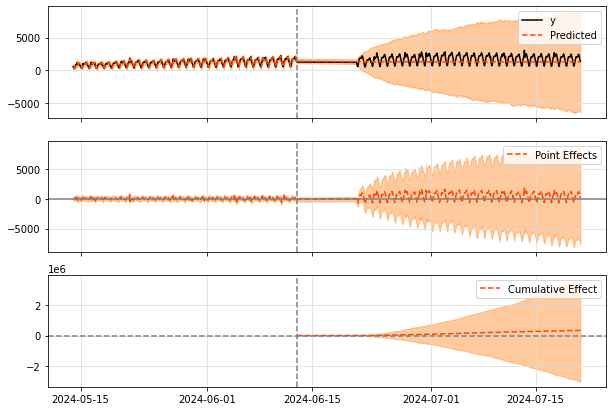

In [73]:
impact_users = CausalImpact(data=pd.Series(df.users), #данные
                      pre_period=period_before, #период до события
                      post_period=period_after) #период после события
impact_users.plot()

In [74]:
print(impact_users.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1747.55            1259986.0
Prediction (s.d.)         1279.96 (2167.06)  922849.12 (1562449.46)
95% CI                    [-3166.85, 5327.87][-2283298.53, 3841392.09]

Absolute effect (s.d.)    467.6 (2167.06)    337136.88 (1562449.46)
95% CI                    [-3580.31, 4914.4] [-2581406.09, 3543284.53]

Relative effect (s.d.)    36.53% (169.31%)   36.53% (169.31%)
95% CI                    [-279.72%, 383.95%][-279.72%, 383.95%]

Posterior tail-area probability p: 0.4
Posterior prob. of a causal effect: 59.54%

For more details run the command: print(impact.summary('report'))


Анализ долгосрочных эффектов флэшмоба показывает, что значительных и статистически значимых изменений в ключевых метриках (CTR, лайки, просмотры и пользователи) не произошло. Вероятности наличия причинного эффекта для всех метрик находятся в районе 50-60%, что не позволяет уверенно утверждать о существовании долгосрочных последствий флэшмоба. Следовательно, можно заключить, что флэшмоб оказал лишь краткосрочное влияние на активность пользователей, не приводя к устойчивым изменениям.